# [Colaboratory]TFLite-ModelMaker-ObjectDetection-Hands-On.ipynb
このノートブックはTensorflow Lite Model Makerを用いて物体検出モデルを作成するハンズオン用スクリプトです(This notebook is a hands-on script for creates a custom object detection model using Tensorflow Lite Model Maker)<br><br>
Colaboratoryのハードウェア アクセラレータ設定をGPUにして実行してください(Set the hardware accelerator setting of Colaboratory to GPU and execute it.)<br><br>
Github URL :https://github.com/Kazuhito00/TFLite-ModelMaker-EfficientDet-Colab-Hands-On

# パッケージインストール(Install the required packages)

In [1]:
!pip install -q tflite-model-maker

     |████████████████████████████████| 593kB 8.6MB/s 
     |████████████████████████████████| 122kB 16.3MB/s 
     |████████████████████████████████| 174kB 15.0MB/s 
     |████████████████████████████████| 71kB 9.7MB/s 
     |████████████████████████████████| 849kB 16.5MB/s 
     |████████████████████████████████| 112kB 28.9MB/s 
     |████████████████████████████████| 92kB 9.8MB/s 
     |████████████████████████████████| 686kB 28.6MB/s 
     |████████████████████████████████| 6.3MB 42.7MB/s 
     |████████████████████████████████| 1.2MB 50.4MB/s 
     |████████████████████████████████| 645kB 50.4MB/s 
     |████████████████████████████████| 1.1MB 48.4MB/s 
     |████████████████████████████████| 358kB 46.6MB/s 
     |████████████████████████████████| 102kB 13.8MB/s 
     |████████████████████████████████| 38.2MB 1.2MB/s 
     |████████████████████████████████| 194kB 54.8MB/s 


# パッケージインポート(Import the required packages)

In [2]:
import os
import numpy as np

from tflite_model_maker import model_spec
from tflite_model_maker import object_detector
from tflite_model_maker.config import ExportFormat
from tflite_model_maker.config import QuantizationConfig

import tensorflow as tf
assert tf.__version__.startswith('2')

tf.get_logger().setLevel('ERROR')
from absl import logging
logging.set_verbosity(logging.ERROR)

# データセット準備(Prepare the dataset)

In [3]:
!mkdir dataset

画像ファイルとcsvファイルを「dataset」ディレクトリに格納してください(Store the image file and csv file in the "dataset" directory)<br><br>
アノテーションのハンズオンを実施しない方や、アノテーション済みのデータを用いて試したい方は、以下の「if False:」を「if True:」に変更して実施してください(If you do not want to perform the annotation hands-on, or if you want to try using the annotated data, change the following "if False:" to "if True:" and execute it.)
![image](https://user-images.githubusercontent.com/37477845/121359484-7fa46d80-c96e-11eb-9491-c262935c4125.png)

In [ ]:
if False:
    !git clone https://github.com/Kazuhito00/TFLite-ModelMaker-EfficientDet-Colab-Hands-On
    !cp -r TFLite-ModelMaker-EfficientDet-Colab-Hands-On/02_dataset\(Annotated\)/* ./dataset

#### データセットCSV読み込み(Read CSV)

In [5]:
dataset_dir = 'dataset'
original_csv_name = 'TFLite-ModelMaker-EfficientDet-Colab-Hands-On-export.csv'

original_csv_path = os.path.join(dataset_dir, original_csv_name)

In [6]:
import pandas as pd

dataset = pd.read_csv(original_csv_path)
dataset.head()

,image,xmin,ymin,xmax,ymax,label
0,000002.jpg,0.000000,315.351545,73.603745,379.251566,fish
1,000002.jpg,416.637763,419.751566,517.477126,530.451593,fish
2,000002.jpg,316.698704,153.351545,434.644797,201.051573,fish
3,000002.jpg,803.788994,178.551573,861.411516,255.951559,fish
4,000003.jpg,0.000000,329.751566,54.696373,380.151552,fish


#### 学習データ/検証データ/テストデータ 分割(Split Training data/validation data/Test data)

In [7]:
# ユニークな名前の画像ファイル数を取得(Get the number of image files with unique names)
image_list = sorted(dataset["image"].unique())
dataset_num = len(dataset["image"].unique())
print('Number of dataset: ' + str(dataset_num))

# 学習データ：60%、検証データ 10%、テストデータ 10%(Training data:60%, validation data:20%, Test data:20%)
train_num = int(0.6 * dataset_num)
validation_num = int(0.2 * dataset_num)
test_num = int(0.2 * dataset_num)
print('Number of Train dataset: ' + str(train_num))
print('Number of Validation dataset: ' + str(validation_num))
print('Number of Test dataset: ' + str(test_num))

Number of dataset: 50
Number of Train dataset: 30
Number of Validation dataset: 10
Number of Test dataset: 10


In [8]:
# 学習データ/検証データ/テストデータ 分割(Split Training data/validation data/Test data)
import random

use_shuffle = False

if use_shuffle is False:
    train_list = image_list[:train_num]
    validation_list = image_list[train_num:train_num + validation_num]
    test_list = image_list[train_num + validation_num:]
else:
    image_shuffle_list = random.sample(image_list, len(image_list))
    train_list = image_shuffle_list[:train_num]
    validation_list = image_shuffle_list[train_num:train_num + validation_num]
    test_list = image_shuffle_list[train_num + validation_num:]

# object_detectorで読み込む形式に変換(Convert to format read by object_detector)
object_detectorでCSV形式のデータセットを読み込む場合には以下の形式でデータを用意します(When handling CSV format data set with object_detector, prepare the data in the following format)
```
TRAIN,dataset/000030.jpg,fish,0.711606,0.825651,,,0.932004,0.963984,,
VALIDATE,dataset/000031.jpg,fish,0.373974,0.082317,,,0.486518,0.253984,,
TEST,dataset/000041.jpg,fish,0.403985,0.183984,,,0.562485,0.320651,,
```

列1(Column1)：TRAIN、VALIDATE、TEST<br>
列2(Column2)：画像格納パス(Image path)<br>
列3(Column3)：クラス ラベル名(Class label name)<br>
列4(Column4)：左上x座標(Upper left x coordinate)<br>
列5(Column5)：左上y座標(Upper left y coordinate)<br>
列6(Column6)：右上x座標(Upper right x coordinate) ※指定不要(No need to specify)<br>
列7(Column7)：右上y座標(Upper right y coordinate) ※指定不要(No need to specify)<br>
列8(Column8)：右下x座標(Lower right x coordinate)<br>
列9(Column9)：右下y座標(Lower right y coordinate)<br>
列10(Column10)：左下x座標(Lower left x coordinate) ※指定不要(No need to specify)<br>
列11(Column11)：左下x座標(Lower left x coordinate) ※指定不要(No need to specify)<br>


In [9]:
import cv2

dataset_list = []

def convert_csv_format(tag, dataset_list, file_list, dataset_dir):
    result_list = []

    for target_file in file_list:
        for index, row in (dataset_list[dataset_list['image'] == target_file]).iterrows():
            file_path = os.path.join(dataset_dir, row.image)
            temp_image = cv2.imread(file_path)

            image_width, image_height = temp_image.shape[1], temp_image.shape[0]
            xmin = row.xmin / image_width
            ymin = row.ymin / image_height
            xmax = row.xmax / image_width
            ymax = row.ymax / image_height

            result_list.append([tag, file_path, row.label, xmin, ymin, '', '', xmax, ymax, '', ''])

    return result_list

result_list = convert_csv_format('TRAIN', dataset, train_list, dataset_dir)
dataset_list.extend(result_list)

result_list = convert_csv_format('VALIDATE', dataset, validation_list, dataset_dir)
dataset_list.extend(result_list)

result_list = convert_csv_format('TEST', dataset, test_list, dataset_dir)
dataset_list.extend(result_list)

In [10]:
# CSVファイルに保存(Save CSV)
import csv

dataset_csv_file = 'dataset.csv'

with open(dataset_csv_file, 'w') as f:
    writer = csv.writer(f)
    writer.writerows(dataset_list)

# Model MakerでCSVファイルを読み込む(Import csv file with Model Maker)

In [11]:
train_data, validation_data, test_data = object_detector.DataLoader.from_csv(dataset_csv_file)

# 物体検出のモデルアーキテクチャを選択(Choose an object detection model archiecture)
このハンズオンではEfficientDet-Lite0を使用します(This Hands on uses the EfficientDet-Lite0 model)<br>
EfficientDet-Lite は、EfficientDetから派生したモバイル/IoT向けのオブジェクト検出モデルのファミリーです<br>(EfficientDet-Lite are a family of mobile/IoT-friendly object detection models derived from the EfficientDet architecture)<br><br>
各 EfficientDet-Lite モデルのパフォーマンスは以下です(The performance of each EfficientDet-Lite model is as follows:)

| Model architecture | Size(MB)* | Latency(ms)** | Average Precision*** |
|--------------------|-----------|---------------|----------------------|
| EfficientDet-Lite0 | 4.4       | 37            | 25.69%               |
| EfficientDet-Lite1 | 5.8       | 49            | 30.55%               |
| EfficientDet-Lite2 | 7.2       | 69            | 33.97%               |
| EfficientDet-Lite3 | 11.4      | 116           | 37.70%               |
| EfficientDet-Lite4 | 19.9      | 260           | 41.96%               |

<i> * 整数量子化モデルのサイズ(Size of the integer quantized models) <br/>
** Pixel 4 で測定したレイテンシ ※CPU 4スレッド(Latency measured on Pixel 4 using 4 threads on CPU) <br/>
*** OCO 2017 検証データセットのmAP(Average Precision is the mAP (mean Average Precision) on the COCO 2017 validation dataset)
</i>

In [12]:
spec = model_spec.get('efficientdet_lite0')

# 訓練(Training)
object_detector.create()を用いてモデルを訓練します(Train the model using object_detector.create())<br>
train_whole_modelにTrueを指定した場合、モデルのヘッド部分のみではなくモデル全体を訓練します<br>(If true is specified for train_whole_model, the entire model is trained, not just the head part of the model)

In [13]:
%%time

model = object_detector.create(
    train_data, 
    model_spec=spec,
    validation_data=validation_data,
    epochs=100,
    batch_size=8, 
    train_whole_model=True, 
)

Epoch 1/100
3/3 [==============================] - 44s 2s/step - det_loss: 1.8252 - cls_loss: 1.1248 - box_loss: 0.0140 - reg_l2_loss: 0.0630 - loss: 1.8882 - learning_rate: 0.0088 - gradient_norm: 1.2512 - val_det_loss: 1.7528 - val_cls_loss: 1.1066 - val_box_loss: 0.0129 - val_reg_l2_loss: 0.0630 - val_loss: 1.8158
Epoch 2/100
3/3 [==============================] - 1s 601ms/step - det_loss: 1.8174 - cls_loss: 1.1139 - box_loss: 0.0141 - reg_l2_loss: 0.0630 - loss: 1.8804 - learning_rate: 0.0100 - gradient_norm: 1.3246 - val_det_loss: 1.7091 - val_cls_loss: 1.0885 - val_box_loss: 0.0124 - val_reg_l2_loss: 0.0630 - val_loss: 1.7721
Epoch 3/100
3/3 [==============================] - 1s 607ms/step - det_loss: 1.7215 - cls_loss: 1.0945 - box_loss: 0.0125 - reg_l2_loss: 0.0630 - loss: 1.7845 - learning_rate: 0.0100 - gradient_norm: 1.3449 - val_det_loss: 1.6529 - val_cls_loss: 1.0572 - val_box_loss: 0.0119 - val_reg_l2_loss: 0.0630 - val_loss: 1.7159
Epoch 4/100
3/3 [======================

# モデル評価(Model evaluate)

In [14]:
model.evaluate(test_data)

1/1 [==============================] - 3s 3s/step



{'AP': 0.3259484,
 'AP50': 0.6609925,
 'AP75': 0.280903,
 'AP_/fish': 0.3259484,
 'APl': 0.628489,
 'APm': 0.25955123,
 'APs': -1.0,
 'ARl': 0.66923076,
 'ARm': 0.38292682,
 'ARmax1': 0.11481482,
 'ARmax10': 0.37407407,
 'ARmax100': 0.45185184,
 'ARs': -1.0}

# TensorFlow Lite形式でのモデルエクスポート(Export to TensorFlow Lite format)
形式：完全整数量子化(Full integer quantization)

デフォルトでのエクスポート形式は完全整数量子化です(The default quantization technique is full integer quantization)

In [15]:
model.export(export_dir='.', tflite_filename='model_int8.tflite')

In [16]:
model.evaluate_tflite('model_int8.tflite', test_data)

10/10 [==============================] - 23s 2s/step



{'AP': 0.3238207,
 'AP50': 0.6851599,
 'AP75': 0.28477708,
 'AP_/fish': 0.3238207,
 'APl': 0.64072216,
 'APm': 0.24981664,
 'APs': -1.0,
 'ARl': 0.6846154,
 'ARm': 0.3,
 'ARmax1': 0.12222222,
 'ARmax10': 0.36851853,
 'ARmax100': 0.39259258,
 'ARs': -1.0}

# TensorFlow Lite形式でのモデルエクスポート(Export to TensorFlow Lite format)
形式：Float16量子化(Float16 quantization)

In [17]:
config = QuantizationConfig.for_float16()
model.export(export_dir='.', tflite_filename='model_fp16.tflite', quantization_config=config)

In [18]:
model.evaluate_tflite('model_fp16.tflite', test_data)

10/10 [==============================] - 1s 81ms/step



{'AP': 0.31571403,
 'AP50': 0.64743817,
 'AP75': 0.27214405,
 'AP_/fish': 0.31571403,
 'APl': 0.62614226,
 'APm': 0.24375543,
 'APs': -1.0,
 'ARl': 0.65384614,
 'ARm': 0.297561,
 'ARmax1': 0.11481482,
 'ARmax10': 0.35925925,
 'ARmax100': 0.38333333,
 'ARs': -1.0}

# 推論(Inference)
形式：完全整数量子化(Full integer quantization)

In [19]:
# モデルロード(Load model)
interpreter = tf.lite.Interpreter(model_path='model_int8.tflite')
interpreter.allocate_tensors()

In [20]:
# 入力情報確認(Check input detail)
input_details = interpreter.get_input_details()
print(input_details)

[{'name': 'serving_default_images:0', 'index': 0, 'shape': array([  1, 320, 320,   3], dtype=int32), 'shape_signature': array([  1, 320, 320,   3], dtype=int32), 'dtype': <class 'numpy.uint8'>, 'quantization': (0.0078125, 127), 'quantization_parameters': {'scales': array([0.0078125], dtype=float32), 'zero_points': array([127], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]


In [21]:
# 出力情報確認(Check output detail)
output_details = interpreter.get_output_details()
print(output_details)

[{'name': 'StatefulPartitionedCall:31', 'index': 598, 'shape': array([ 1, 25,  4], dtype=int32), 'shape_signature': array([ 1, 25,  4], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}, {'name': 'StatefulPartitionedCall:32', 'index': 599, 'shape': array([ 1, 25], dtype=int32), 'shape_signature': array([ 1, 25], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}, {'name': 'StatefulPartitionedCall:33', 'index': 600, 'shape': array([ 1, 25], dtype=int32), 'shape_signature': array([ 1, 25], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_po

In [22]:
# クラスラベル確認(Check class label)
class_labels = ['???'] * model.model_spec.config.num_classes
label_map = model.model_spec.config.label_map
for label_id, label_name in label_map.as_dict().items():
    class_labels[label_id-1] = label_name

print(class_labels)

['fish', '???']


In [23]:
# 推論用関数(Function for inference)
def run_inference_int8_single_image(
        interpreter,
        input_image,
        input_shape=(320, 320),
):
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()

    x = input_image[:, :, [2, 1, 0]]  # BGR2RGB
    x = cv2.resize(x, (input_shape[0], input_shape[1]))
    x = x.reshape(1, x.shape[0], x.shape[1], x.shape[2])
    x = x.astype(np.uint8)

    interpreter.set_tensor(input_details[0]['index'], x)
    interpreter.invoke()

    boxes = interpreter.get_tensor(output_details[0]['index'])
    classes = interpreter.get_tensor(output_details[1]['index'])
    scores = interpreter.get_tensor(output_details[2]['index'])
    num = interpreter.get_tensor(output_details[3]['index'])

    return np.squeeze(boxes), np.squeeze(classes), np.squeeze(scores), int(num[0])

In [24]:
# サンプル画像読み込み(Load sample image)
test_image = cv2.imread('dataset/000041.jpg')

In [25]:
# 推論(Inference)
bboxes, classes, scores, num = run_inference_int8_single_image(
    interpreter,
    test_image
)

In [26]:
# 推論結果描画(Inference result drawing)
import copy

score_th = 0.3

debug_image = copy.deepcopy(test_image)
debug_image_width, debug_image_height = debug_image.shape[1], debug_image.shape[0]

for i in range(num):
    score = scores[i]
    bbox = bboxes[i]
    class_id = classes[i].astype(np.int)

    if score < score_th:
        continue

    x1, y1 = int(bbox[1] * debug_image_width), int(bbox[0] * debug_image_height)
    x2, y2 = int(bbox[3] * debug_image_width), int(bbox[2] * debug_image_height)

    cv2.putText(
        debug_image, 'ID:' + str(class_id) + ' ' +
        class_labels[class_id] + ' ' + '{:.3f}'.format(score),
        (x1, y1 - 15), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2,
        cv2.LINE_AA)
    cv2.rectangle(debug_image, (x1, y1), (x2, y2), (255, 255, 255), 2)

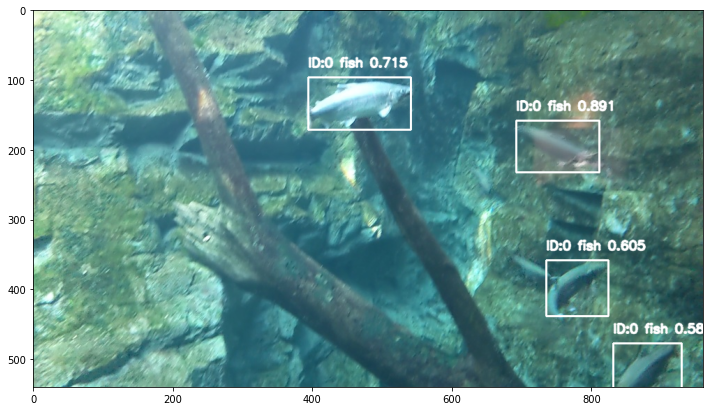

In [27]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 7))
plt.imshow(cv2.cvtColor(debug_image, cv2.COLOR_BGR2RGB) )

# 推論(Inference)
形式：Float16量子化(Float16 quantization)

In [28]:
# モデルロード(Load model)
interpreter = tf.lite.Interpreter(model_path='model_fp16.tflite', num_threads=1)
interpreter.allocate_tensors()

In [29]:
# 入力情報確認(Check input detail)
input_details = interpreter.get_input_details()
print(input_details)

[{'name': 'serving_default_images:0', 'index': 0, 'shape': array([  1, 320, 320,   3], dtype=int32), 'shape_signature': array([  1, 320, 320,   3], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]


In [30]:
# 出力情報確認(Check output detail)
output_details = interpreter.get_output_details()
print(output_details)

[{'name': 'StatefulPartitionedCall:3', 'index': 524, 'shape': array([ 1, 25,  4], dtype=int32), 'shape_signature': array([ 1, 25,  4], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}, {'name': 'StatefulPartitionedCall:2', 'index': 525, 'shape': array([ 1, 25], dtype=int32), 'shape_signature': array([ 1, 25], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}, {'name': 'StatefulPartitionedCall:1', 'index': 526, 'shape': array([ 1, 25], dtype=int32), 'shape_signature': array([ 1, 25], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_point

In [31]:
# クラスラベル確認(Check class label)
class_labels = ['???'] * model.model_spec.config.num_classes
label_map = model.model_spec.config.label_map
for label_id, label_name in label_map.as_dict().items():
    class_labels[label_id-1] = label_name

print(class_labels) 

['fish', '???']


In [32]:
# 推論用関数(Function for inference)
def run_inference_fp16_single_image(
        interpreter,
        input_image,
        input_shape=(320, 320),
):
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()

    x = input_image[:, :, [2, 1, 0]]  # BGR2RGB
    x = cv2.resize(x, (input_shape[0], input_shape[1]))
    x = x.reshape(1, x.shape[0], x.shape[1], x.shape[2])
    x = x.astype(np.float32)
    x /= 255.0

    interpreter.set_tensor(input_details[0]['index'], x)
    interpreter.invoke()

    boxes = interpreter.get_tensor(output_details[0]['index'])
    classes = interpreter.get_tensor(output_details[1]['index'])
    scores = interpreter.get_tensor(output_details[2]['index'])
    num = interpreter.get_tensor(output_details[3]['index'])

    return np.squeeze(boxes), np.squeeze(classes), np.squeeze(scores), int(num[0])

In [33]:
# サンプル画像読み込み(Load sample image)
test_image = cv2.imread('dataset/000041.jpg')

In [34]:
# 推論(Inference)
bboxes, classes, scores, num = run_inference_fp16_single_image(
    interpreter,
    test_image
)

In [35]:
# 推論結果描画(Inference result drawing)
import copy

score_th = 0.3

debug_image = copy.deepcopy(test_image)
debug_image_width, debug_image_height = debug_image.shape[1], debug_image.shape[0]

for i in range(num):
    score = scores[i]
    bbox = bboxes[i]
    class_id = classes[i].astype(np.int)

    if score < score_th:
        continue

    x1, y1 = int(bbox[1] * debug_image_width), int(bbox[0] * debug_image_height)
    x2, y2 = int(bbox[3] * debug_image_width), int(bbox[2] * debug_image_height)

    cv2.putText(
        debug_image, 'ID:' + str(class_id) + ' ' +
        class_labels[class_id] + ' ' + '{:.3f}'.format(score),
        (x1, y1 - 15), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2,
        cv2.LINE_AA)
    cv2.rectangle(debug_image, (x1, y1), (x2, y2), (255, 255, 255), 2)

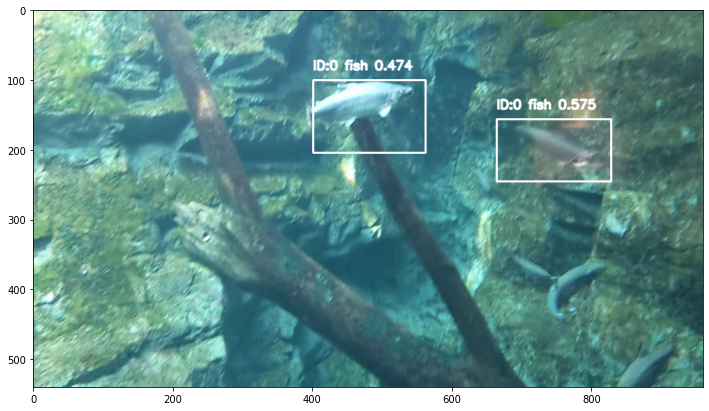

In [36]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 7))
plt.imshow(cv2.cvtColor(debug_image, cv2.COLOR_BGR2RGB) )